In [1]:
from data.data_loader import MIMICDataloader
from data.paths import TabularDataPaths
import os
from PIL import Image
import pandas as pd

In [2]:
## load the data from disk 

## Q: what are those data we want to process? or what's the plan we gonna do?
## A: We gonna implement a class called "MimicCDataLoader" that able to load (1) patients data in CORE (2) triage data in ED (3) Eye tracking data from REFLACX (5) the labels from CheXpert or Nagibio



## TODO:
## [x] 1. Make a dataload that allow us to load the data and clean some missing values (Also list out the columns with missing values).
## [x] 2. We gonna confirm that if a patient has at least one lession, it means this person will not get a normal diagnois vice versa. 
## [ ] 3. load the view angle restriction as the natural restrictions, we will only use the PA view in the REFLACX dataset.


In [3]:
## Define all paths here.
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [4]:
## Test load a patient data
test_patient_id = "10002428"
test_patient_folder_path = os.path.join(XAMI_MIMIC_PATH,f"patient_{test_patient_id}")
assert(os.path.isdir(test_patient_folder_path))

In [5]:
assert(os.path.isfile(TabularDataPaths.SpreadSheet.get_sreadsheet(XAMI_MIMIC_PATH ,TabularDataPaths.SpreadSheet.cxr_meta)))
assert(os.path.isfile(TabularDataPaths.PatientDataPaths.get_patient_path(XAMI_MIMIC_PATH, "19968039" ,TabularDataPaths.PatientDataPaths.Core.admissions)))

In [6]:
mimic_dataloader = MIMICDataloader(XAMI_MIMIC_PATH)

In [7]:
loaded_data = mimic_dataloader.get_data(
    [
        "d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401",
        "e22e9b84-4106ded2-20cae2bb-b27bac4f-0f94be91"
    ],
    [
        TabularDataPaths.PatientDataPaths.ED.triage,
        TabularDataPaths.PatientDataPaths.Core.patients,
        TabularDataPaths.PatientDataPaths.REFLACX.REFLACXStudy.anomaly_location_ellipses,
        TabularDataPaths.PatientDataPaths.CXR_JPG.cxr_meta,
    ],
    load_image=True,
    load_report_text='reflacx'
)


In [8]:
loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular']['Core\\patients.csv']

,Unnamed: 0,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,39287,17799242,F,79,2166,2014 - 2016,NaN


In [9]:
real_age = loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular']['Core\\patients.csv'].iloc[0]['anchor_age'] + (int(str(loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular']["CXR-JPG\\cxr_meta.csv"].iloc[0]['StudyDate'])[:4]) - loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular']['Core\\patients.csv'].iloc[0]['anchor_year'])

In [10]:
loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular']["CXR-JPG\\cxr_meta.csv"]

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id
0,294084,d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401,17799242,53582712,CHEST (PORTABLE AP),AP,3050,2539,21670826,204251.546,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.167083e+13,NaN


In [11]:
cxr_meta_df = pd.read_csv(TabularDataPaths.SpreadSheet.get_sreadsheet(XAMI_MIMIC_PATH ,TabularDataPaths.SpreadSheet.cxr_meta))

In [12]:
cxr_meta_with_stay_id_only_df = pd.read_csv(TabularDataPaths.SpreadSheet.get_sreadsheet(XAMI_MIMIC_PATH ,TabularDataPaths.SpreadSheet.cxr_meta_with_stay_id_only))

In [13]:
cxr_meta_df['ViewCodeSequence_CodeMeaning'].value_counts()

postero-anterior    2044
antero-posterior    1633
Erect                 10
Name: ViewCodeSequence_CodeMeaning, dtype: int64

In [14]:
mimic_dataloader.reflacx_metadata['Nodule'] == 1

0       False
1       False
2       False
3        True
4       False
        ...  
3047    False
3048    False
3049    False
3050    False
3051    False
Name: Nodule, Length: 3052, dtype: bool

In [15]:
reflacx_meta_df = pd.read_csv(TabularDataPaths.SpreadSheet.get_sreadsheet(XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.REFLACX.metadata))

In [16]:
# load core_patients 
core_patients_df = pd.read_csv("D:\mimic-iv-1.0\mimic-iv-1.0\core\patients.csv")

In [17]:
reflacx_meta_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation', 'Emphysema',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Mass', 'Nodule', 'Other', 'Pleural effusion',
       'Pleural thickening', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality'],
      dtype='object')

In [18]:
reflacx_meta_df['Lung nodule or mass'] = (~reflacx_meta_df['Lung nodule or mass'].isna() & reflacx_meta_df['Lung nodule or mass'] > 0) | (~reflacx_meta_df['Mass'].isna() & reflacx_meta_df['Mass'] > 0) | (~reflacx_meta_df['Nodule'].isna() & reflacx_meta_df['Nodule'] > 0)
del reflacx_meta_df['Mass']
del reflacx_meta_df['Nodule']


reflacx_meta_df['High lung volume / emphysema'] = (~reflacx_meta_df['High lung volume / emphysema'].isna() & reflacx_meta_df['High lung volume / emphysema']>0) | (~reflacx_meta_df['Emphysema'].isna() & reflacx_meta_df['Emphysema']>0) 
del reflacx_meta_df['Emphysema']


reflacx_meta_df['Pleural abnormality'] = (~reflacx_meta_df['Pleural abnormality'].isna() & reflacx_meta_df['Pleural abnormality'] > 0) | (~reflacx_meta_df['Pleural thickening'].isna() & reflacx_meta_df['Pleural thickening'] > 0) | (~reflacx_meta_df['Pleural effusion'].isna() & reflacx_meta_df['Pleural effusion'] > 0)
del reflacx_meta_df['Pleural thickening']
del reflacx_meta_df['Pleural effusion']

In [19]:
reflacx_meta_df.fillna(0)

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,0.0,0.0,0.0,0.0,False,0.0,True,False
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,2502,P300R939601,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d9661ff6-877ac981-a20a8810-92309d46-173008ad,19991135,2544,3056,0.0,...,False,0.0,5.0,0.0,0.0,0.0,False,0.0,False,True
3048,2503,P300R331925,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d8f5555c-d8bcf97c-3a9d5596-17b9f854-6e15d081,19991135,1736,2022,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,True
3049,2504,P300R336111,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d04bbcbd-5143439e-50ebe9a8-71380f67-44f8d127,19991135,2544,3056,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,False
3050,2505,P300R179177,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,7cfe7acc-65b0b548-feb77772-04c46d33-76a03230,19997367,2402,2712,0.0,...,True,0.0,0.0,0.0,0.0,0.0,False,0.0,False,True


In [20]:
reflacx_meta_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Other', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality'],
      dtype='object')

In [21]:
triage_df = pd.read_csv('D:\mimic-iv-ed-1.0\mimic-iv-ed-1.0\ed\\triage.csv')

In [22]:
triage_df.head(5)

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,15585360,37573921,97.0,87.0,18.0,100.0,150.0,71.0,10.0,3.0,
1,17192424,34160628,98.6,82.0,NaN,100.0,111.0,81.0,3.0,3.0,
2,15248757,32172727,97.1,112.0,20.0,100.0,147.0,97.0,8.0,4.0,
3,16648037,38946064,98.5,59.0,18.0,99.0,160.0,86.0,2.0,2.0,
4,13492931,39828574,100.6,90.0,16.0,96.0,107.0,55.0,0.0,3.0,'


In [23]:
patient_triage_df = pd.read_csv('D:\XAMI-MIMIC\patient_10002428\ED\\triage.csv')

In [24]:
patient_triage_df.head(5)

,Unnamed: 0,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,86242,10002428,37376268,97.2,98.0,14.0,98.0,158.0,89.0,0.0,2.0,BRBPR
1,137902,10002428,32007337,98.5,125.0,22.0,100.0,111.0,63.0,4.0,2.0,"DIARRHEA,FEVER"
2,249957,10002428,33227245,99.4,109.0,16.0,100.0,138.0,118.0,0.0,3.0,LARYNGITIS/SOB WITH TALKING
3,253994,10002428,34982171,98.4,100.0,16.0,96.0,126.0,74.0,5.0,3.0,LEFT HIP FX
4,259246,10002428,32822973,100.2,95.0,28.0,100.0,99.0,47.0,NaN,2.0,LETHARGY/SOB


In [25]:
triage_df[triage_df['subject_id'].eq(10002428)]

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
86242,10002428,37376268,97.2,98.0,14.0,98.0,158.0,89.0,0.0,2.0,BRBPR
137902,10002428,32007337,98.5,125.0,22.0,100.0,111.0,63.0,4.0,2.0,"DIARRHEA,FEVER"
249957,10002428,33227245,99.4,109.0,16.0,100.0,138.0,118.0,0.0,3.0,LARYNGITIS/SOB WITH TALKING
253994,10002428,34982171,98.4,100.0,16.0,96.0,126.0,74.0,5.0,3.0,LEFT HIP FX
259246,10002428,32822973,100.2,95.0,28.0,100.0,99.0,47.0,NaN,2.0,LETHARGY/SOB
339824,10002428,33978784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESP ARREST
402788,10002428,38216551,98.0,100.0,16.0,97.0,172.0,100.0,4.0,3.0,"s/p Fall, L Shoulder pain"


In [26]:
core_patients_df.head(5)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN


In [27]:
merged_df = reflacx_meta_df.merge(cxr_meta_df, 'left', left_on='dicom_id', right_on='dicom_id', suffixes=("","cxr")).merge(core_patients_df, 'left', on="subject_id", suffixes=("","_patient")).merge(triage_df, 'left', left_on='stay_id', right_on='stay_id', suffixes=("","_triage"))

In [28]:
merged_df = merged_df[~merged_df['eye_tracking_data_discarded']]
merged_df = merged_df[~merged_df['stay_id'].isna()]
merged_df['age'] = merged_df['anchor_age'] + (merged_df['StudyDate'].apply(lambda x: int(str(x)[:4])) - merged_df['anchor_year'])

In [29]:
merged_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Other', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality', 'Unnamed: 0cxr', 'subject_idcxr', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'in_eye_gaze',
       'in_reflacx', 'StudyDateTime', 'stay_id', 'gender', 'anchor_age',


In [30]:
merged_df

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,age
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,98.1,90.0,18.0,99.0,184.0,75.0,13.0,3.0,Dyspnea,69.0
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,98.1,90.0,18.0,99.0,184.0,75.0,13.0,3.0,Dyspnea,69.0
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,98.1,90.0,18.0,99.0,184.0,75.0,13.0,3.0,Dyspnea,69.0
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,98.1,90.0,18.0,99.0,184.0,75.0,13.0,3.0,Dyspnea,69.0
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,98.1,90.0,18.0,99.0,184.0,75.0,13.0,3.0,Dyspnea,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,2475,P300R833708,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,a2fe8aae-2fe32131-b47c4e5b-090f4c13-88e7ac97,19875621,2544,3056,NaN,...,98.0,101.0,18.0,98.0,NaN,NaN,8.0,3.0,DYSPNEA,43.0
3023,2478,P300R918521,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,a2a80c63-8b9575dc-bc08895e-40392d6a-d7fc17d5,19884194,2544,3056,NaN,...,97.5,76.0,16.0,100.0,141.0,66.0,2.0,3.0,"Back pain, N/V",31.0
3027,2482,P300R611251,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,2b20dcdf-4077bc16-48fc8eb5-265ef218-f6552cb0,19906407,2881,2544,NaN,...,97.5,115.0,16.0,99.0,187.0,104.0,8.0,2.0,TYLENOL OVERDOSE,38.0
3028,2483,P300R519683,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,92134f99-0e73faba-1280ad81-218c68ba-933a85c5,19907884,2544,3056,NaN,...,98.6,108.0,18.0,96.0,180.0,109.0,10.0,3.0,"Abd pain, n/v/d",42.0


In [31]:
# Pick the column we want.
needed_columns = [
       
       # ids 
       'id', 'dicom_id', 'subject_id', 'stay_id', 'study_id', 'split'
       
       # image meta
       'ViewPosition','image_size_x', 'image_size_y',
       
       # patients 
       'age', 'gender',

       # triage 
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity'

              
       # labels
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Other', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality', 
       
       ]

In [32]:
reflacx_meta_df.head(5)

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,False,NaN,False,False
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,False,NaN,False,False
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,NaN,NaN,NaN,NaN,False,NaN,False,False
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,NaN,NaN,NaN,NaN,False,NaN,True,False
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,False,NaN,False,False


In [33]:
cxr_meta_df.head(5)

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id
0,177,fa771fa1-d9571d07-bff8f655-327734a7-6e10b29d,10002428,59258773,CHEST (PORTABLE AP),AP,3056,2544,21560419,92717.109,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.156042e+12,NaN
1,181,4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3,10002430,53254222,CHEST (PA AND LAT),PA,3056,2544,21250928,160736.171,CHEST (PA AND LAT),postero-anterior,Erect,True,False,2.125093e+13,31293660.0
2,266,dcdc4bd9-4301b111-2a65a814-ee8e7bc5-7f0b9a5a,10003400,56466802,CHEST (PORTABLE AP),AP,3056,2544,21361209,133738.015,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.136121e+13,33678912.0
3,497,5bdabba9-388f6646-ac06b5f5-f68b2fd2-3630de21,10011607,55814288,CHEST (PA AND LAT),AP,3056,2544,21820111,230933.250,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.182011e+13,37054412.0
4,539,4a629500-9c3281ca-90bab490-9b6ac9c1-e5e6a580,10012261,53728467,CHEST (PORTABLE AP),AP,2544,3056,21750906,191151.453,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.175091e+13,38668412.0


In [34]:
merged_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Other', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality', 'Unnamed: 0cxr', 'subject_idcxr', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'in_eye_gaze',
       'in_reflacx', 'StudyDateTime', 'stay_id', 'gender', 'anchor_age',


In [35]:
"labels"

needed_columns = ['id', 'split', 'dicom_id', 'subject_id', 'image_size_x', 'image_size_y', ]

In [36]:
cxr_meta_df.head(5)

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id
0,177,fa771fa1-d9571d07-bff8f655-327734a7-6e10b29d,10002428,59258773,CHEST (PORTABLE AP),AP,3056,2544,21560419,92717.109,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.156042e+12,NaN
1,181,4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3,10002430,53254222,CHEST (PA AND LAT),PA,3056,2544,21250928,160736.171,CHEST (PA AND LAT),postero-anterior,Erect,True,False,2.125093e+13,31293660.0
2,266,dcdc4bd9-4301b111-2a65a814-ee8e7bc5-7f0b9a5a,10003400,56466802,CHEST (PORTABLE AP),AP,3056,2544,21361209,133738.015,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.136121e+13,33678912.0
3,497,5bdabba9-388f6646-ac06b5f5-f68b2fd2-3630de21,10011607,55814288,CHEST (PA AND LAT),AP,3056,2544,21820111,230933.250,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.182011e+13,37054412.0
4,539,4a629500-9c3281ca-90bab490-9b6ac9c1-e5e6a580,10012261,53728467,CHEST (PORTABLE AP),AP,2544,3056,21750906,191151.453,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.175091e+13,38668412.0


In [37]:
mimic_dataloader.reflacx_metadata

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,2502,P300R939601,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d9661ff6-877ac981-a20a8810-92309d46-173008ad,19991135,2544,3056,NaN,...,False,NaN,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3048,2503,P300R331925,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d8f5555c-d8bcf97c-3a9d5596-17b9f854-6e15d081,19991135,1736,2022,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3049,2504,P300R336111,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d04bbcbd-5143439e-50ebe9a8-71380f67-44f8d127,19991135,2544,3056,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3050,2505,P300R179177,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,7cfe7acc-65b0b548-feb77772-04c46d33-76a03230,19997367,2402,2712,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [38]:
cxr_meta_with_stay_id_only_df[cxr_meta_with_stay_id_only_df['in_reflacx']]

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id
1,266,dcdc4bd9-4301b111-2a65a814-ee8e7bc5-7f0b9a5a,10003400,56466802,CHEST (PORTABLE AP),AP,3056,2544,21361209,133738.015,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.136121e+13,33678912
2,497,5bdabba9-388f6646-ac06b5f5-f68b2fd2-3630de21,10011607,55814288,CHEST (PA AND LAT),AP,3056,2544,21820111,230933.250,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.182011e+13,37054412
3,539,4a629500-9c3281ca-90bab490-9b6ac9c1-e5e6a580,10012261,53728467,CHEST (PORTABLE AP),AP,2544,3056,21750906,191151.453,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.175091e+13,38668412
5,583,38a5ffc8-93297f03-3f0a14e4-aa8ca225-7e968b5b,10013324,51191158,CHEST (PA AND LAT),PA,3056,2544,21231028,171318.828,CHEST (PA AND LAT),postero-anterior,Erect,False,True,2.123103e+13,30504536
7,1835,e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a,10046166,57379357,CHEST (PA AND LAT),AP,2544,3056,21330321,115719.296,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.133032e+13,37162571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,372496,a2fe8aae-2fe32131-b47c4e5b-090f4c13-88e7ac97,19875621,55102074,CHEST (PA AND LAT),PA,3056,2544,21890614,201251.328,CHEST (PA AND LAT),postero-anterior,Erect,False,True,2.189061e+13,32582616
1217,372735,a2a80c63-8b9575dc-bc08895e-40392d6a-d7fc17d5,19884194,57912042,CHEST (PORTABLE AP),AP,3056,2544,21730520,154247.171,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.173052e+13,36719043
1218,373535,2b20dcdf-4077bc16-48fc8eb5-265ef218-f6552cb0,19906407,57296330,CHEST (PA AND LAT),AP,2544,2881,21930704,235349.343,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.193070e+13,33352559
1219,373603,92134f99-0e73faba-1280ad81-218c68ba-933a85c5,19907884,57427881,CHEST (PA AND LAT),PA,3056,2544,21841031,190357.031,CHEST (PA AND LAT),postero-anterior,Erect,False,True,2.184103e+13,39112538


In [39]:
mimic_dataloader.reflacx_metadata

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,2502,P300R939601,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d9661ff6-877ac981-a20a8810-92309d46-173008ad,19991135,2544,3056,NaN,...,False,NaN,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3048,2503,P300R331925,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d8f5555c-d8bcf97c-3a9d5596-17b9f854-6e15d081,19991135,1736,2022,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3049,2504,P300R336111,test,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,d04bbcbd-5143439e-50ebe9a8-71380f67-44f8d127,19991135,2544,3056,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3050,2505,P300R179177,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p19/...,7cfe7acc-65b0b548-feb77772-04c46d33-76a03230,19997367,2402,2712,NaN,...,True,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [40]:
cxr_meta_df['ViewCodeSequence_CodeMeaning'].value_counts()

postero-anterior    2044
antero-posterior    1633
Erect                 10
Name: ViewCodeSequence_CodeMeaning, dtype: int64

In [41]:
# ! We should use reflacx_id to search all other fields, because the reflacx do multiple studies on single dicom_id.

In [42]:
dicom_id = "ad0f405d-43502246-89ea5db3-b41c5ae9-48a92ffc"
mimic_dataloader.reflacx_metadata[mimic_dataloader.reflacx_metadata['dicom_id'].eq(dicom_id)]

,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality


In [43]:
cxr_meta_df[cxr_meta_df['dicom_id'].eq(dicom_id)]

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id


In [44]:
## To know the dicom_id and it's relationship,

# 1. we find the dicom_id in reflacx_meta
# 2. find the view in cxr_meta
# 3. open the image to test

In [45]:
loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]["image"].shape # the [Rows, Columns]

(3050, 2539)

In [46]:
loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular'][TabularDataPaths.PatientDataPaths.Core.patients]

,Unnamed: 0,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,39287,17799242,F,79,2166,2014 - 2016,NaN


In [47]:
loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]['tabular'][TabularDataPaths.PatientDataPaths.ED.triage]

,Unnamed: 0,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,35582,17799242,37378221,98.0,112.0,22.0,96.0,96.0,64.0,4.0,2.0,"Abd pain, Transfer"


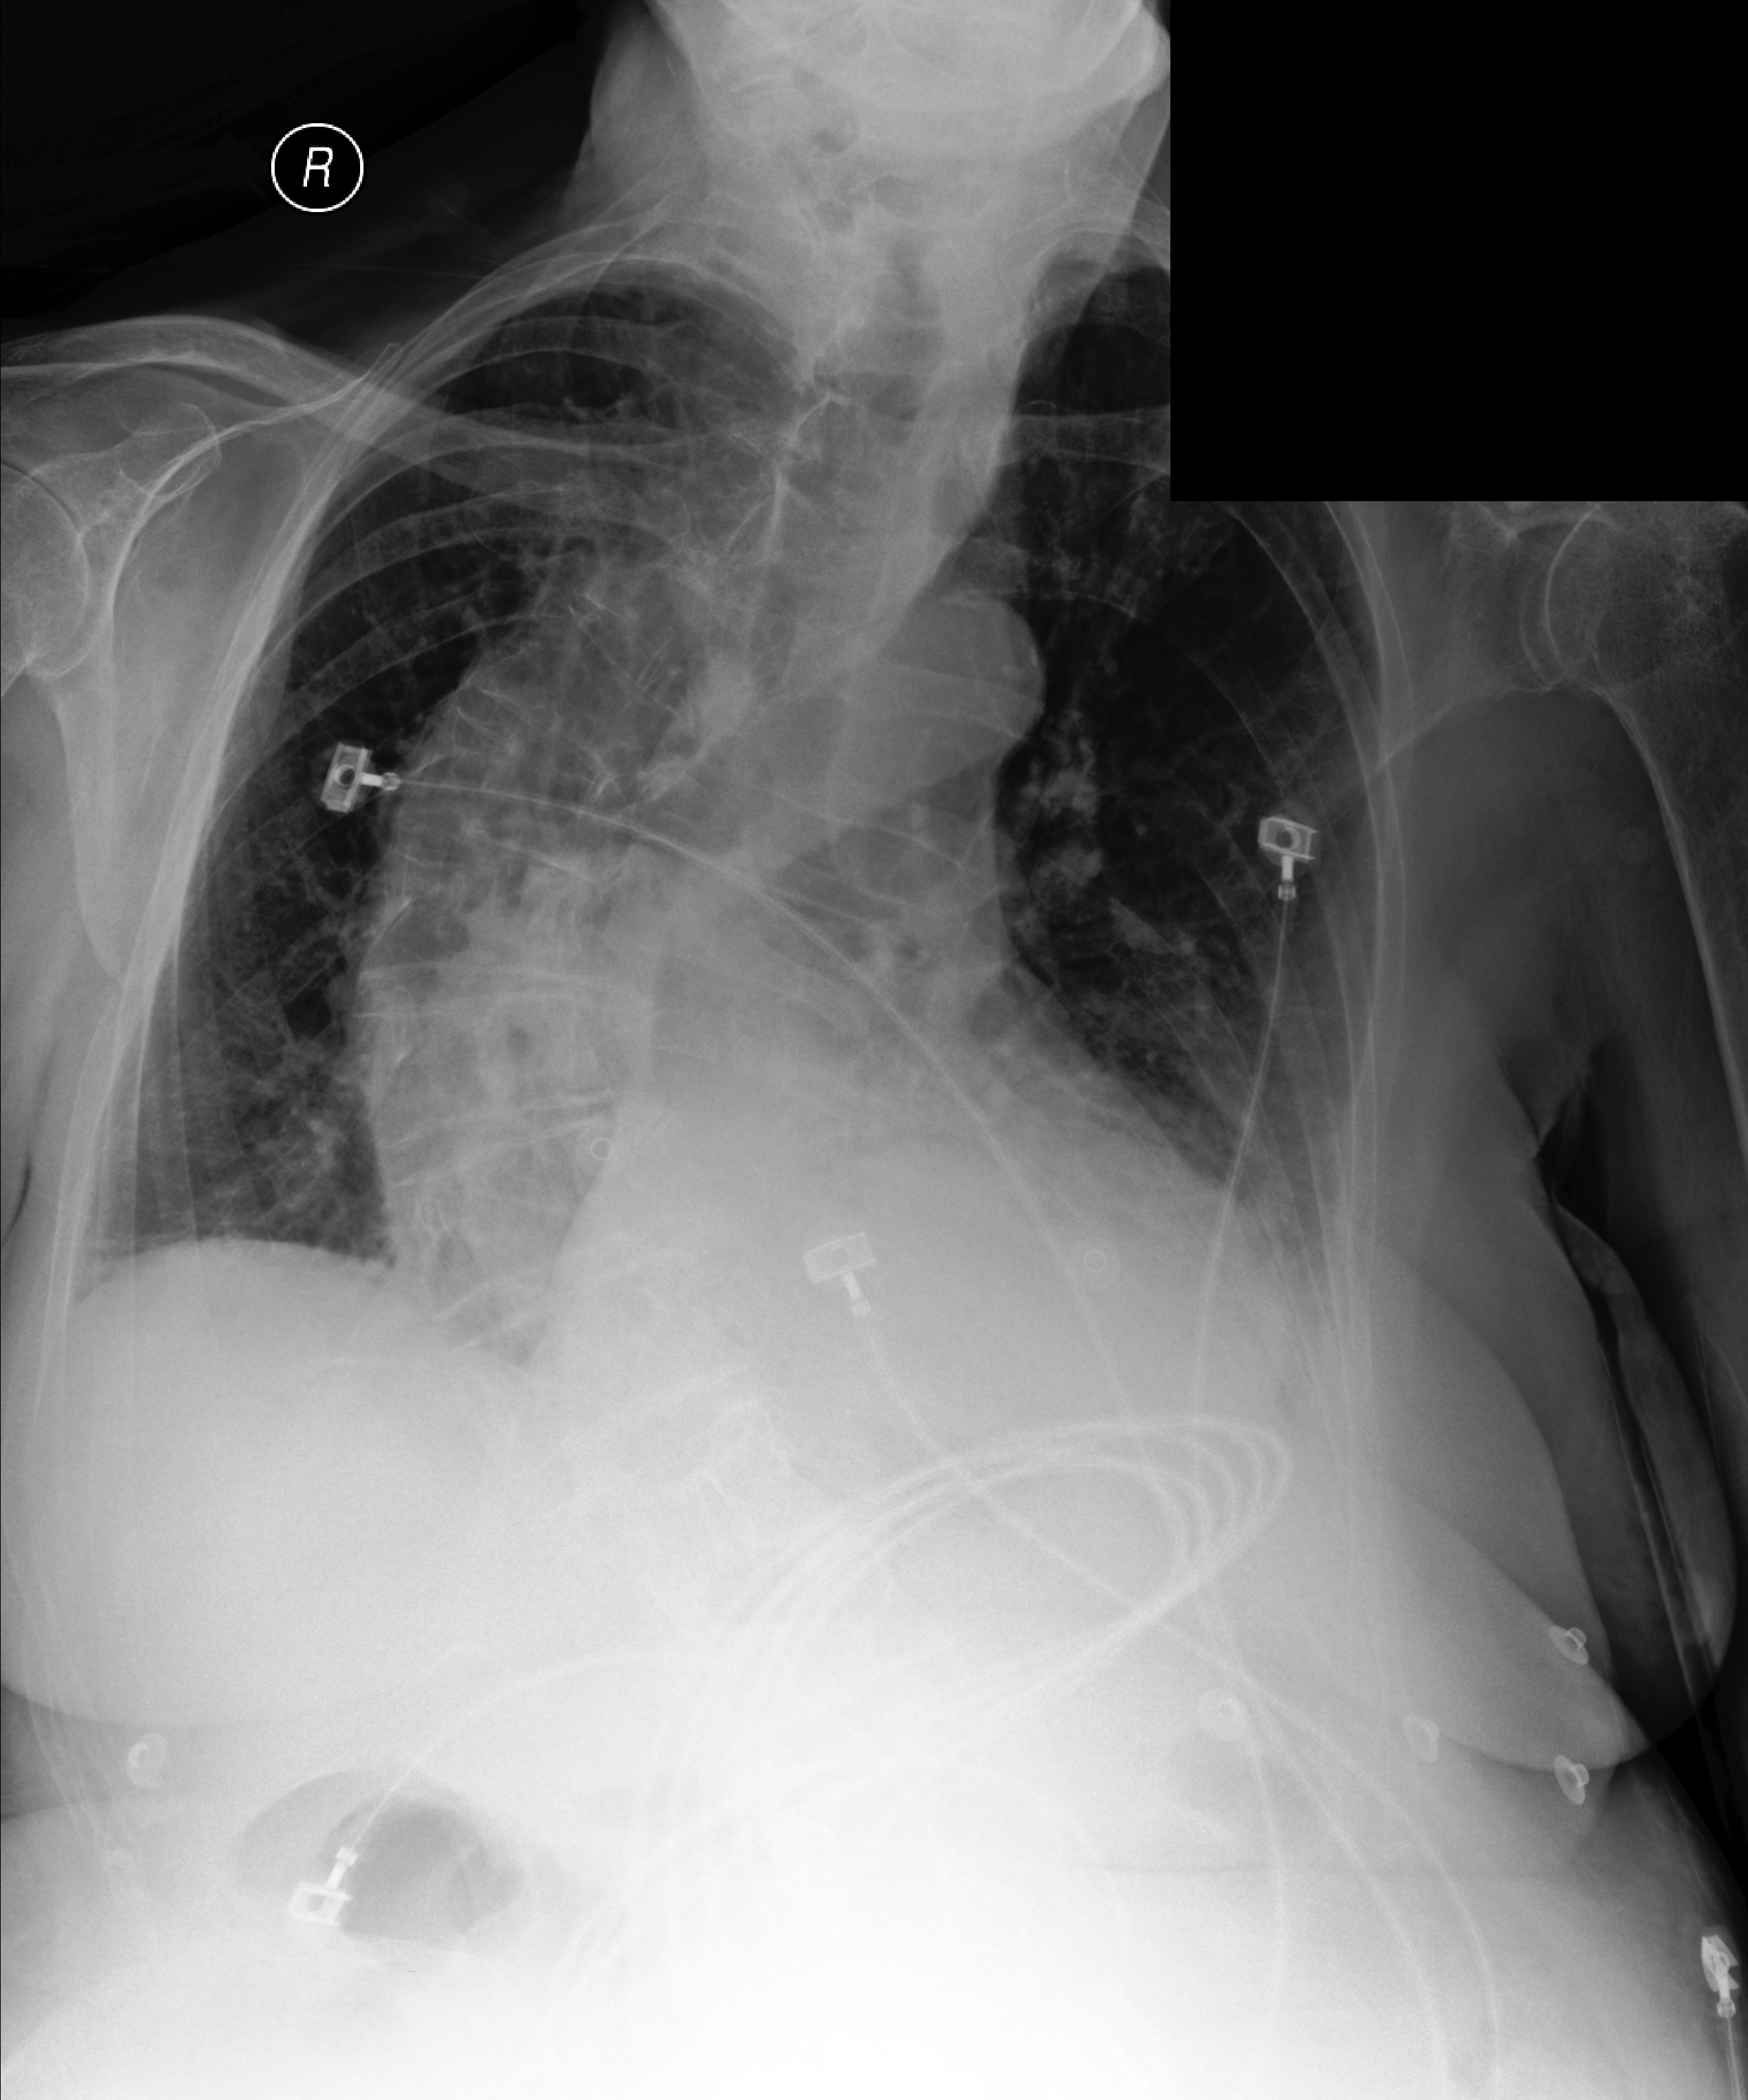

In [48]:
# show image.
# plt.imshow(Image.fromarray(loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]["image"]))
Image.fromarray(loaded_data["d1bdf0b5-cf2d6aee-0685203b-23334088-a5ed5401"]["image"])